## STMO Project

In [7]:
pip install osmnx

  Obtaining dependency information for osmnx from https://files.pythonhosted.org/packages/fe/11/4a8e774bc97cb64b2accfb1c4a8a06e5b5649dfd60b224c5c40a5d73d24a/osmnx-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for geopandas>=1.0 from https://files.pythonhosted.org/packages/c4/64/7d344cfcef5efddf9cf32f59af7f855828e9d74b5f862eddf5bfd9f25323/geopandas-1.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for shapely>=2.0 from https://files.pythonhosted.org/packages/b1/5a/6a67d929c467a1973b6bb9f0b00159cc343b02bf9a8d26db1abd2f87aa23/shapely-2.0.6-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for pyogrio>=0.7.2 from https://files.pythonhosted.org/packages/94/8d/24f21e6a93ca418231aee3bddade7a0766c89c523832f29e08a8860f83e6/pyogrio-0.10.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for pyproj>=3.3.0 from https://files.pythonhosted.org/packages/26/0c/b084e8839a117eaad8cb4fbaa81bbb24c6f183de0ee95c6c4e2770ab6f09/pyp

In [10]:
import random
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import osmnx as ox

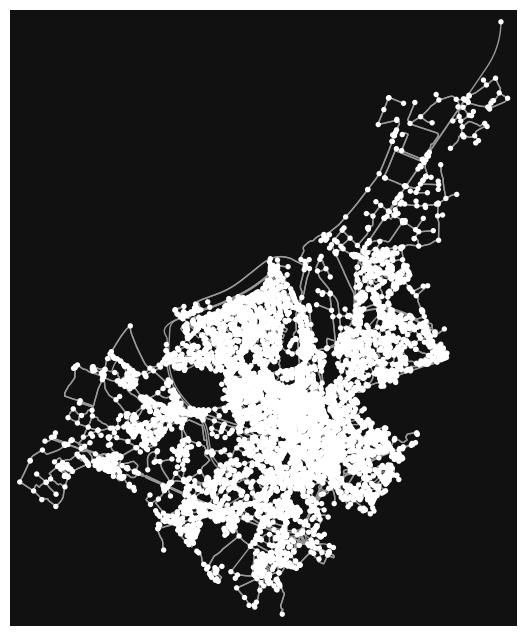

In [11]:
place_name = 'Ghent'
graph = ox.graph_from_place(place_name, network_type='drive')
fig, ax = ox.plot_graph(graph)
plt.show()